In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

pd.set_option('display.max_rows', 100)

In [2]:
oura = pd.read_csv(
    "data/oura.csv",
    index_col="day",
    parse_dates=True,
    usecols=["day", "bedtime_end", "type"],
)
# rename bedtime_end to wake
oura.rename(columns={"bedtime_end": "wake"}, inplace=True)
# only keep sleeps
oura = oura[oura.type == "long_sleep"]
# convert bedtime to datetime type; ignore timezone; keep only time
oura.wake = pd.to_datetime(
    oura.wake.apply(lambda x: x[11:-6] if len(x) == 25 else x[11:]), utc=True
)
# convert to timedelta
oura.wake = pd.to_timedelta(
    (oura.wake.dt.hour * 60 + oura.wake.dt.minute) * 60 + oura.wake.dt.second, unit="S"
)

In [3]:
daylio = pd.read_csv(
    "data/daylio.csv",
    index_col="full_date",
    parse_dates=True,
    usecols=["mood", "full_date"],
)
# convert moods to ordinal
mood_map = {"awful": -2, "bad": -1, "meh": 0, "good": 1, "rad": 2}
inv_mood_map = {v:k for k,v in mood_map.items()}
daylio.mood =  daylio.mood.map(mood_map)

In [4]:
# join dfs
mood_wakeup = daylio.join(oura).dropna()

/var/folders/my/lvxg1n852nq3vf2vvjqcrzp80000gn/T/ipykernel_24126/1889797851.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


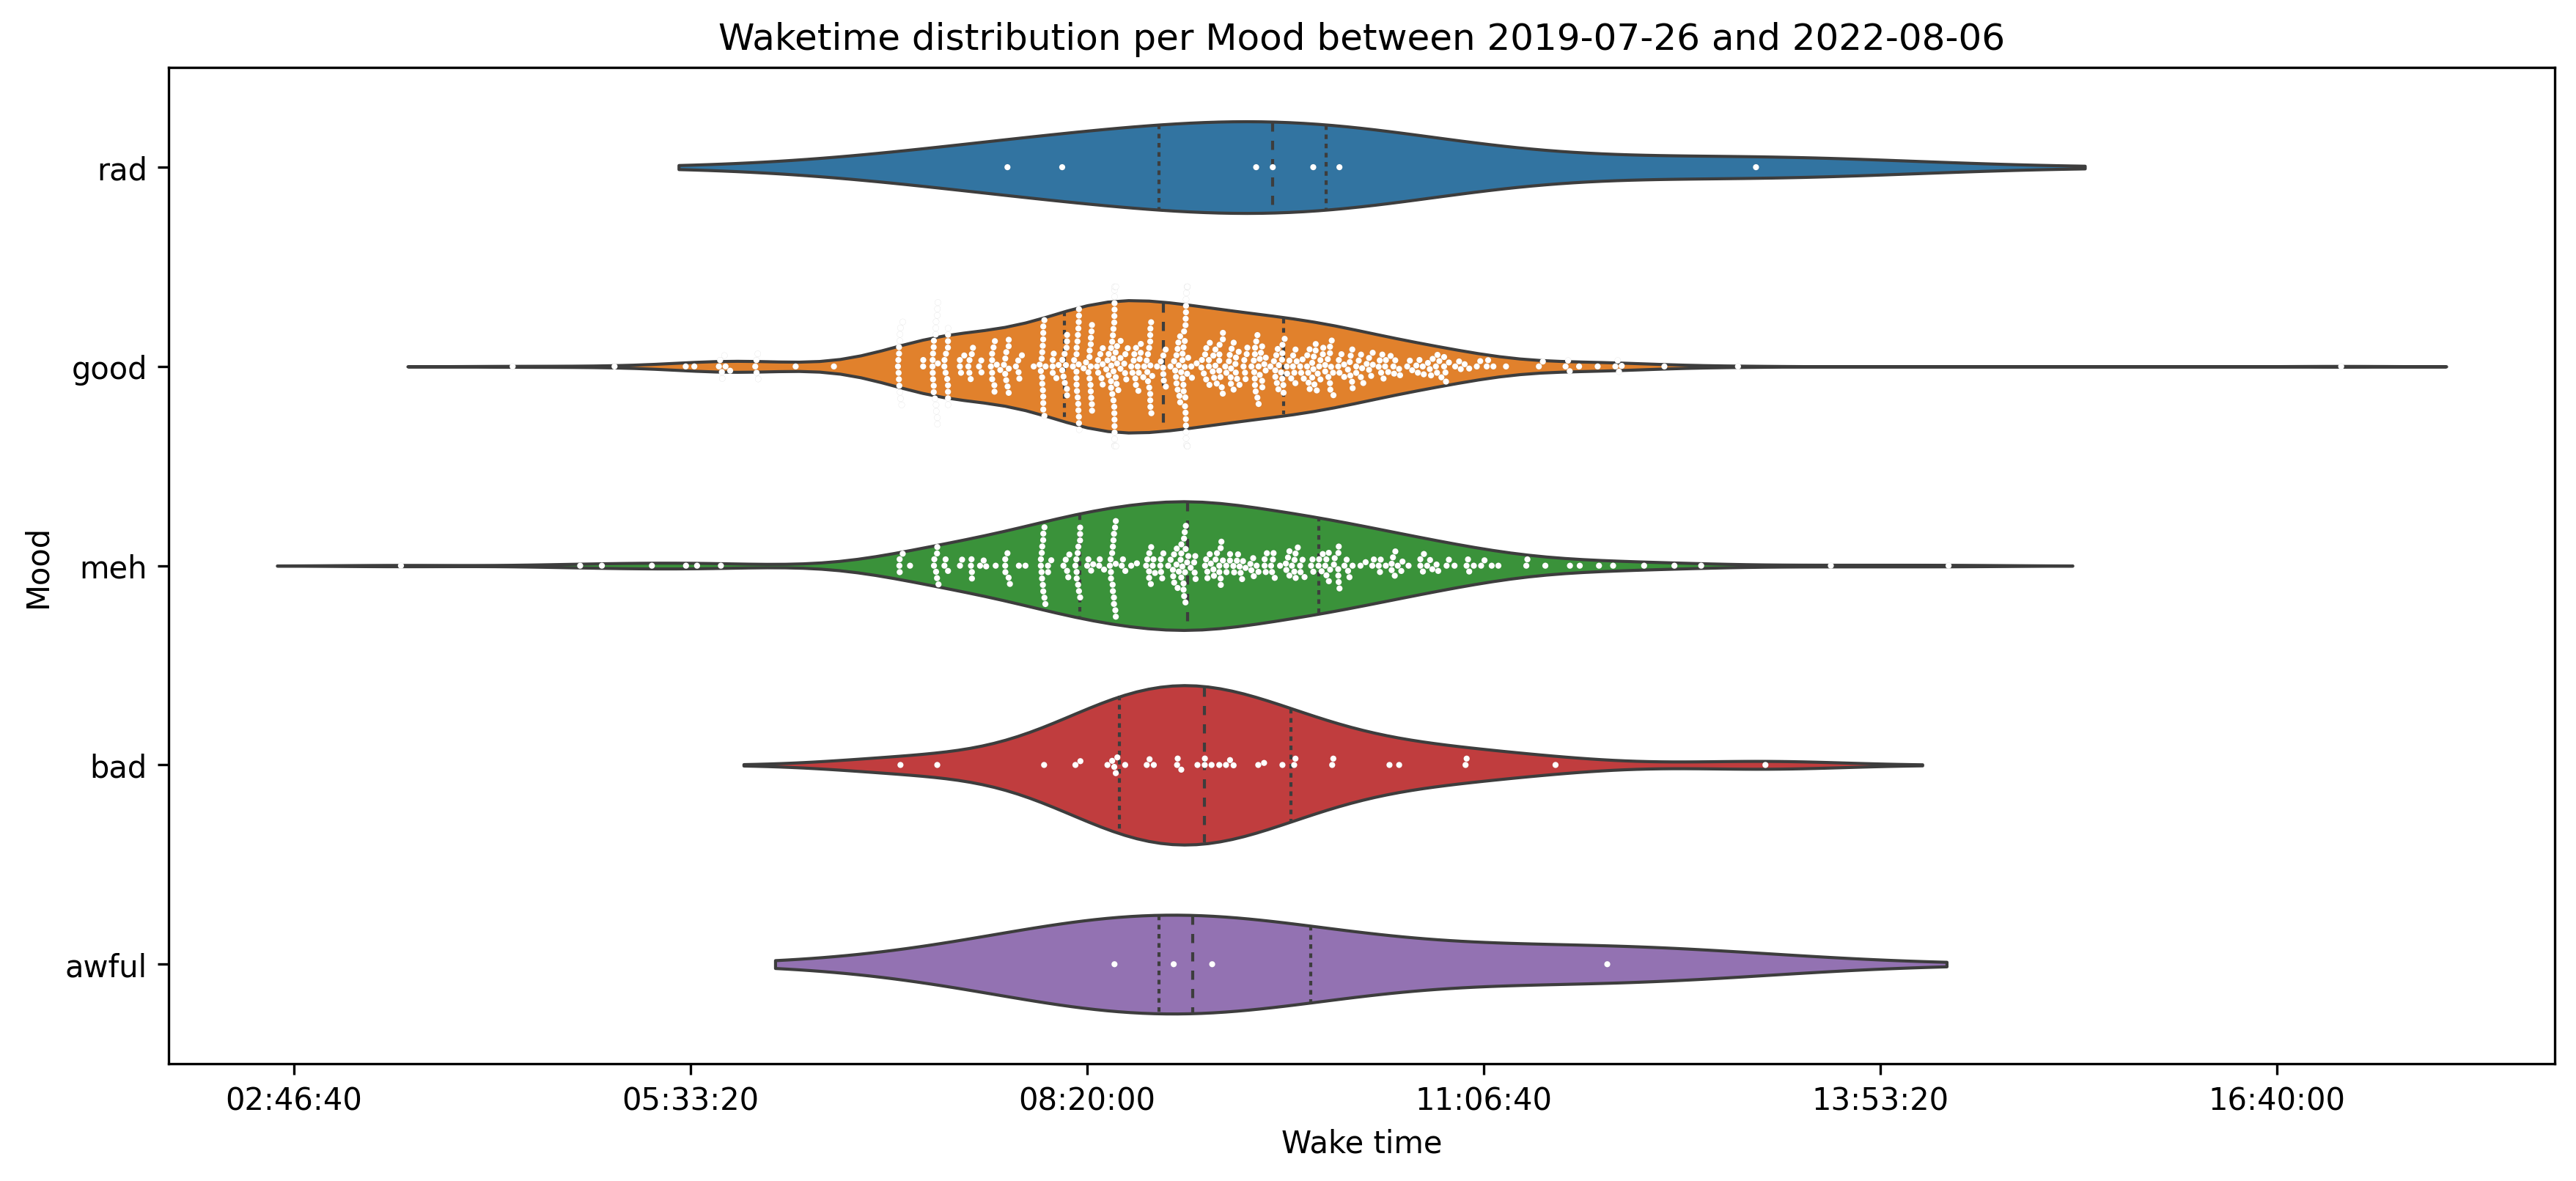

In [5]:
f, ax = plt.subplots(1, 1, figsize=(14, 6), dpi=300)
sns.violinplot(
    y=mood_wakeup.mood,
    x=mood_wakeup.wake.dt.total_seconds(),
    orient="h",
    order=sorted(mood_map.values(), reverse=True),
    scale="area",
    inner="quartile",
    linewidth=1,
)
sns.swarmplot(
    y=mood_wakeup.mood,
    x=mood_wakeup.wake.dt.total_seconds(),
    orient="h",
    order=sorted(mood_map.values(), reverse=True),
    color="white",
    size=2,
    edgecolor="black",
    linewidth=0.01,
)
ax.set_xticklabels(
    [time.strftime("%H:%M:%S", time.gmtime(tick)) for tick in ax.get_xticks()]
)
ax.set_xlabel("Wake time")

ax.set_yticklabels(list(mood_map.keys())[::-1])
ax.set_ylabel("Mood")

ax.set_title(
    "Waketime distribution per Mood between "
    f"{mood_wakeup.index.min().date()} and {mood_wakeup.index.max().date()}"
)

plt.savefig("/Users/thesofakillers/Desktop/mood_wake.png", dpi=300, bbox_inches="tight", )
plt.show()